# importing necessary libararies

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import joblib
import pickle 



# reading dataset

In [60]:
dataset = pd.read_csv('../Datasets/regression.csv')
dataset.head()

,property_id,location_id,page_url,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size,Area Category
0,237062,3325,https://www.zameen.com/Property/g_10_g_10_2_gr...,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,4 Marla,For Sale,2,2/4/2019,NaN,NaN,Marla,4.0,0-5 Marla
1,346905,3236,https://www.zameen.com/Property/e_11_2_service...,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,5.6 Marla,For Sale,3,5/4/2019,NaN,NaN,Marla,5.6,5-10 Marla
2,386513,764,https://www.zameen.com/Property/islamabad_g_15...,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,8 Marla,For Sale,5,7/17/2019,NaN,NaN,Marla,8.0,5-10 Marla
3,656161,340,https://www.zameen.com/Property/islamabad_bani...,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,2 Kanal,For Sale,4,4/5/2019,NaN,NaN,Kanal,2.0,1-5 Kanal
4,841645,3226,https://www.zameen.com/Property/dha_valley_dha...,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,8 Marla,For Sale,3,7/10/2019,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,Marla,8.0,5-10 Marla


# Data Preprocessing

In [61]:
dataset.isna().sum()

# Droping id's and unique data of examples before dropping duplicates

drop_colums=['property_id', 'location_id', 'page_url']
df = dataset.drop(columns= drop_colums, axis=1)

df

,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size,Area Category
0,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,4 Marla,For Sale,2,2/4/2019,NaN,NaN,Marla,4.0,0-5 Marla
1,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,5.6 Marla,For Sale,3,5/4/2019,NaN,NaN,Marla,5.6,5-10 Marla
2,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,8 Marla,For Sale,5,7/17/2019,NaN,NaN,Marla,8.0,5-10 Marla
3,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,2 Kanal,For Sale,4,4/5/2019,NaN,NaN,Kanal,2.0,1-5 Kanal
4,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,8 Marla,For Sale,3,7/10/2019,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,Marla,8.0,5-10 Marla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168440,House,26500000,Gadap Town,Karachi,Sindh,25.029909,67.137192,0,9.6 Marla,For Sale,6,7/18/2019,Al Shahab Enterprises,Shahmir,Marla,9.6,5-10 Marla
168441,House,12500000,Gadap Town,Karachi,Sindh,25.017951,67.136393,0,8 Marla,For Sale,3,7/18/2019,Al Shahab Enterprises,Shahmir,Marla,8.0,5-10 Marla
168442,House,27000000,Gadap Town,Karachi,Sindh,25.015384,67.116330,0,9.6 Marla,For Sale,6,7/18/2019,Al Shahab Enterprises,Shahmir,Marla,9.6,5-10 Marla
168443,House,11000000,Gadap Town,Karachi,Sindh,25.013265,67.120818,0,7.8 Marla,For Sale,3,7/18/2019,Al Shahab Enterprises,Shahmir,Marla,7.8,5-10 Marla


In [62]:
df = df.drop_duplicates()

df

,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size,Area Category
0,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,4 Marla,For Sale,2,2/4/2019,NaN,NaN,Marla,4.0,0-5 Marla
1,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,5.6 Marla,For Sale,3,5/4/2019,NaN,NaN,Marla,5.6,5-10 Marla
2,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,8 Marla,For Sale,5,7/17/2019,NaN,NaN,Marla,8.0,5-10 Marla
3,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,2 Kanal,For Sale,4,4/5/2019,NaN,NaN,Kanal,2.0,1-5 Kanal
4,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,8 Marla,For Sale,3,7/10/2019,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,Marla,8.0,5-10 Marla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168440,House,26500000,Gadap Town,Karachi,Sindh,25.029909,67.137192,0,9.6 Marla,For Sale,6,7/18/2019,Al Shahab Enterprises,Shahmir,Marla,9.6,5-10 Marla
168441,House,12500000,Gadap Town,Karachi,Sindh,25.017951,67.136393,0,8 Marla,For Sale,3,7/18/2019,Al Shahab Enterprises,Shahmir,Marla,8.0,5-10 Marla
168442,House,27000000,Gadap Town,Karachi,Sindh,25.015384,67.116330,0,9.6 Marla,For Sale,6,7/18/2019,Al Shahab Enterprises,Shahmir,Marla,9.6,5-10 Marla
168443,House,11000000,Gadap Town,Karachi,Sindh,25.013265,67.120818,0,7.8 Marla,For Sale,3,7/18/2019,Al Shahab Enterprises,Shahmir,Marla,7.8,5-10 Marla


In [63]:
# droping N/A values

df = df.dropna()

df.isna().sum()

property_type    0
price            0
location         0
city             0
province_name    0
latitude         0
longitude        0
baths            0
area             0
purpose          0
bedrooms         0
date_added       0
agency           0
agent            0
Area Type        0
Area Size        0
Area Category    0
dtype: int64

In [64]:
# chagning marla and kanal to meter to keep consistent in data representing

marla_mask = df['Area Type'] == "Marla"
df.loc[marla_mask, 'Area Size'] *= 25.2929
df.loc[~marla_mask, 'Area Size'] *= 505.857
df=df.drop(columns=['Area Type'],axis=1)
df

,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,agency,agent,Area Size,Area Category
4,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,8 Marla,For Sale,3,7/10/2019,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,202.34320,5-10 Marla
7,Flat,7800000,E-11,Islamabad,Islamabad Capital,33.698244,72.984238,2,6.2 Marla,For Sale,2,5/5/2019,Ettemad Enterprises,Balqiaz Marwat,156.81598,5-10 Marla
8,House,50000000,DHA Defence,Islamabad,Islamabad Capital,33.540894,73.095732,7,1 Kanal,For Sale,7,10/19/2018,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,505.85700,1-5 Kanal
9,Penthouse,40000000,F-11,Islamabad,Islamabad Capital,33.679211,72.988787,5,1 Kanal,For Sale,5,6/27/2019,Crown Associate,Abrar Ahmed,505.85700,1-5 Kanal
10,Flat,35000000,Diplomatic Enclave,Islamabad,Islamabad Capital,33.728873,73.119628,3,7.1 Marla,For Sale,3,6/3/2019,Al Sahar Estate,Zahid H. Usmani,179.57959,5-10 Marla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168440,House,26500000,Gadap Town,Karachi,Sindh,25.029909,67.137192,0,9.6 Marla,For Sale,6,7/18/2019,Al Shahab Enterprises,Shahmir,242.81184,5-10 Marla
168441,House,12500000,Gadap Town,Karachi,Sindh,25.017951,67.136393,0,8 Marla,For Sale,3,7/18/2019,Al Shahab Enterprises,Shahmir,202.34320,5-10 Marla
168442,House,27000000,Gadap Town,Karachi,Sindh,25.015384,67.116330,0,9.6 Marla,For Sale,6,7/18/2019,Al Shahab Enterprises,Shahmir,242.81184,5-10 Marla
168443,House,11000000,Gadap Town,Karachi,Sindh,25.013265,67.120818,0,7.8 Marla,For Sale,3,7/18/2019,Al Shahab Enterprises,Shahmir,197.28462,5-10 Marla


In [65]:
# Define numeric columns
numeric_columns = ['price', 'baths', 'Area Size', 'bedrooms']

# Function to visualize data distribution using box plots

def visualize_boxplot(df, columns):
    for col in columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(y=df[col])
        plt.title('Box Plot - ' + col)
        plt.ylabel(col)
        plt.show()

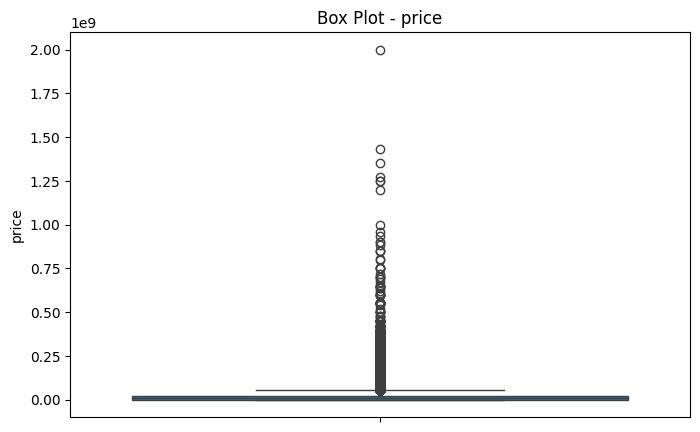

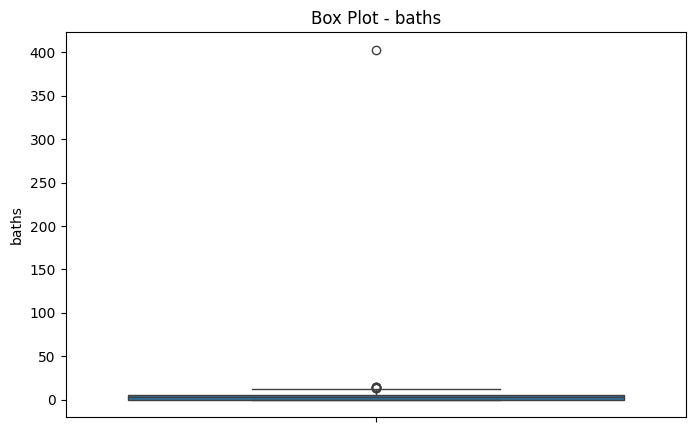

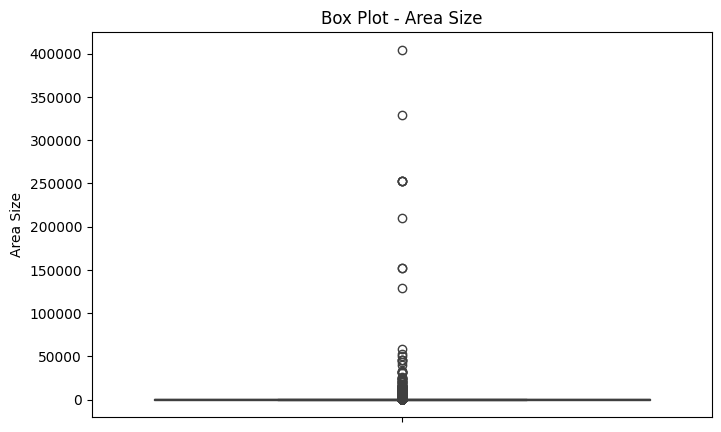

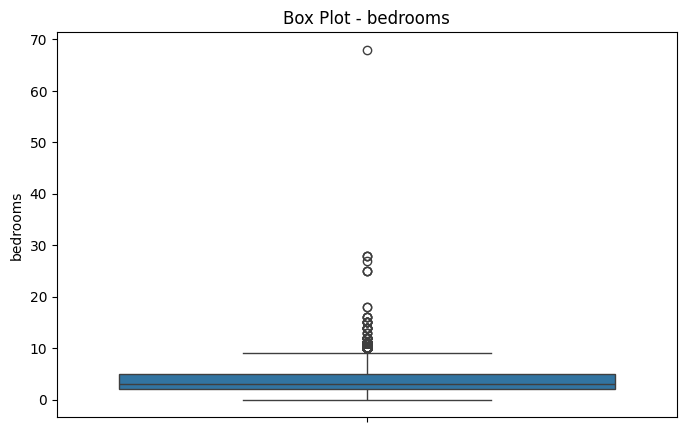

In [66]:
# Visualize data distribution using box plots before handling outliers
visualize_boxplot(df, numeric_columns)



new_df=df.copy()
for col in numeric_columns:
    Q1 = new_df[col].quantile(0.25)
    Q3 = new_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    new_df[col] = np.where(
        new_df[col] > upper_bound,
        upper_bound,
        np.where(
            new_df[col] < lower_bound,
            lower_bound,
            new_df[col]
        )
    )
df = new_df

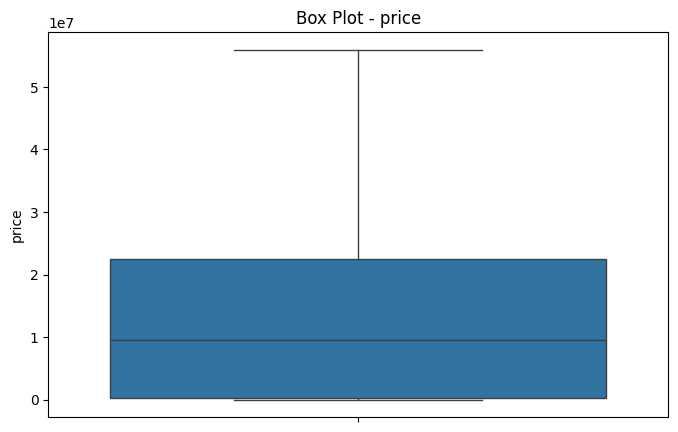

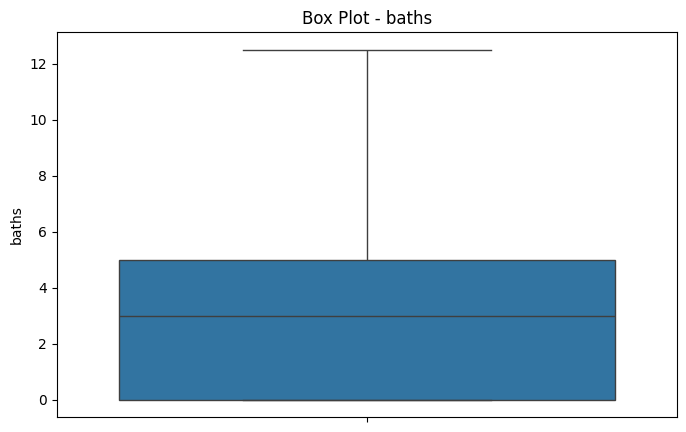

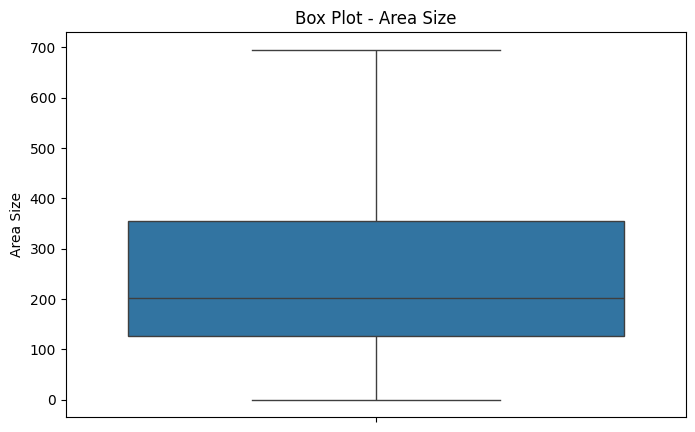

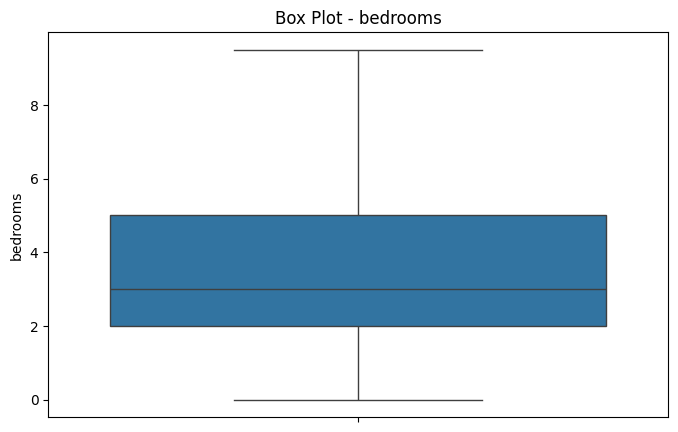

In [67]:
# visualize df after removing outliers
visualize_boxplot(df, numeric_columns)

# Data selection

In [68]:
# droping unneeded features

drop_colums=['date_added','Area Category', 'area','latitude', 'longitude']
df = df.drop(columns= drop_colums, axis=1)

df

,property_type,price,location,city,province_name,baths,purpose,bedrooms,agency,agent,Area Size
4,House,7000000.0,DHA Defence,Islamabad,Islamabad Capital,3.0,For Sale,3.0,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,202.34320
7,Flat,7800000.0,E-11,Islamabad,Islamabad Capital,2.0,For Sale,2.0,Ettemad Enterprises,Balqiaz Marwat,156.81598
8,House,50000000.0,DHA Defence,Islamabad,Islamabad Capital,7.0,For Sale,7.0,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,505.85700
9,Penthouse,40000000.0,F-11,Islamabad,Islamabad Capital,5.0,For Sale,5.0,Crown Associate,Abrar Ahmed,505.85700
10,Flat,35000000.0,Diplomatic Enclave,Islamabad,Islamabad Capital,3.0,For Sale,3.0,Al Sahar Estate,Zahid H. Usmani,179.57959
...,...,...,...,...,...,...,...,...,...,...,...
168440,House,26500000.0,Gadap Town,Karachi,Sindh,0.0,For Sale,6.0,Al Shahab Enterprises,Shahmir,242.81184
168441,House,12500000.0,Gadap Town,Karachi,Sindh,0.0,For Sale,3.0,Al Shahab Enterprises,Shahmir,202.34320
168442,House,27000000.0,Gadap Town,Karachi,Sindh,0.0,For Sale,6.0,Al Shahab Enterprises,Shahmir,242.81184
168443,House,11000000.0,Gadap Town,Karachi,Sindh,0.0,For Sale,3.0,Al Shahab Enterprises,Shahmir,197.28462


# Data Scaling

In [69]:
# Intializing a scaler to scale our numreic data

scaler = RobustScaler()
target_scaler= RobustScaler()


df[['baths', 'bedrooms', 'Area Size']]=scaler.fit_transform(df[['baths', 'bedrooms', 'Area Size']])

df[['price']]=target_scaler.fit_transform(df[['price']])


with open('scaler.pkl','wb') as f :
    pickle.dump(scaler, f) 
    

with open('target_scaler.pkl','wb') as u :
    pickle.dump(target_scaler, u) 
    

# displaying the dataset after scaling numeric data
df.head()

df


,property_type,price,location,city,province_name,baths,purpose,bedrooms,agency,agent,Area Size
4,House,-0.116561,DHA Defence,Islamabad,Islamabad Capital,0.0,For Sale,0.000000,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,0.000000
7,Flat,-0.080696,E-11,Islamabad,Islamabad Capital,-0.2,For Sale,-0.333333,Ettemad Enterprises,Balqiaz Marwat,-0.200000
8,House,1.811172,DHA Defence,Islamabad,Islamabad Capital,0.8,For Sale,1.333333,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,1.333329
9,Penthouse,1.362862,F-11,Islamabad,Islamabad Capital,0.4,For Sale,0.666667,Crown Associate,Abrar Ahmed,1.333329
10,Flat,1.138707,Diplomatic Enclave,Islamabad,Islamabad Capital,0.0,For Sale,0.000000,Al Sahar Estate,Zahid H. Usmani,-0.100000
...,...,...,...,...,...,...,...,...,...,...,...
168440,House,0.757644,Gadap Town,Karachi,Sindh,-0.6,For Sale,1.000000,Al Shahab Enterprises,Shahmir,0.177778
168441,House,0.130010,Gadap Town,Karachi,Sindh,-0.6,For Sale,0.000000,Al Shahab Enterprises,Shahmir,0.000000
168442,House,0.780059,Gadap Town,Karachi,Sindh,-0.6,For Sale,1.000000,Al Shahab Enterprises,Shahmir,0.177778
168443,House,0.062763,Gadap Town,Karachi,Sindh,-0.6,For Sale,0.000000,Al Shahab Enterprises,Shahmir,-0.022222


# Encoding Categorical Data

In [70]:
# Let's say 'property_type' is the categorical variable you want to encode

# Using pandas' get_dummies function to perform one-hot encoding
categorical_columns = ['property_type', 'city', 'province_name', 'purpose', 'location', 'agent', 'agency']



encoder = TargetEncoder(cols=categorical_columns)
df_encoded = encoder.fit_transform(df[categorical_columns],df['price'])

df=df.drop(columns=categorical_columns)

df

df = pd.concat([df_encoded, df], axis=1)


with open('encoder.pkl','wb') as f :
    pickle.dump(encoder, f) 

df



,property_type,city,province_name,purpose,location,agent,agency,price,baths,bedrooms,Area Size
4,0.495936,0.047120,0.047120,0.539992,0.769079,0.275079,0.302859,-0.116561,0.0,0.000000,0.000000
7,-0.034886,0.047120,0.047120,0.539992,-0.110208,0.208077,0.075739,-0.080696,-0.2,-0.333333,-0.200000
8,0.495936,0.047120,0.047120,0.539992,0.769079,0.275079,0.302859,1.811172,0.8,1.333333,1.333329
9,0.222067,0.047120,0.047120,0.539992,0.101169,0.368374,0.353792,1.362862,0.4,0.666667,1.333329
10,-0.034886,0.047120,0.047120,0.539992,0.069191,0.473267,0.208631,1.138707,0.0,0.000000,-0.100000
...,...,...,...,...,...,...,...,...,...,...,...
168440,0.495936,0.292763,0.292763,0.539992,-0.034717,0.323387,0.375193,0.757644,-0.6,1.000000,0.177778
168441,0.495936,0.292763,0.292763,0.539992,-0.034717,0.323387,0.375193,0.130010,-0.6,0.000000,0.000000
168442,0.495936,0.292763,0.292763,0.539992,-0.034717,0.323387,0.375193,0.780059,-0.6,1.000000,0.177778
168443,0.495936,0.292763,0.292763,0.539992,-0.034717,0.323387,0.375193,0.062763,-0.6,0.000000,-0.022222


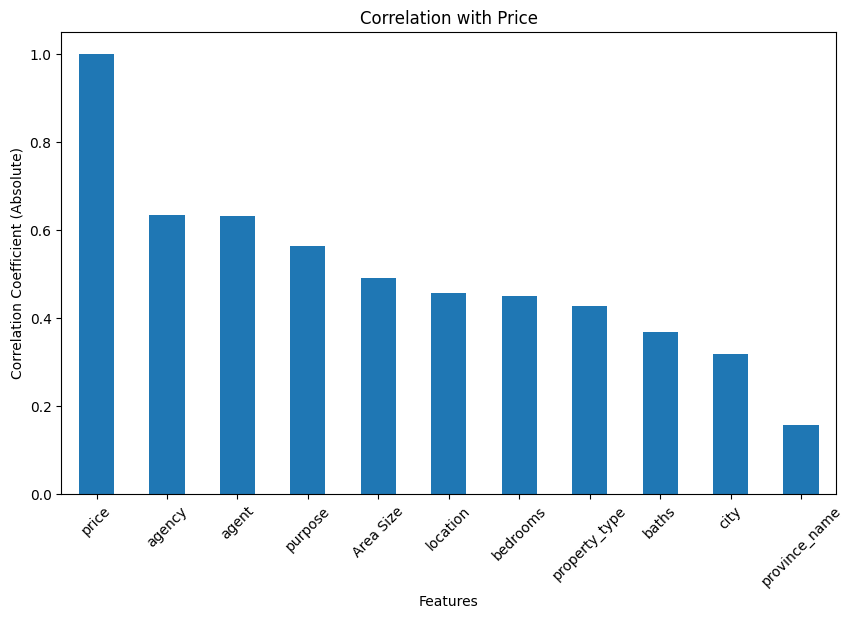

In [71]:
# Compute Pearson correlation coefficients
correlation_with_price = df.corr()['price'].abs().sort_values(ascending=False)

# Plotting the correlation coefficients
plt.figure(figsize=(10, 6))
correlation_with_price.plot(kind='bar')
plt.title('Correlation with Price')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient (Absolute)')
plt.xticks(rotation=45)
plt.show()

# splitting data

In [72]:
X = df.drop(columns=['price'], axis=1)
y = df[['price']]

X.shape, y.shape

X

,property_type,city,province_name,purpose,location,agent,agency,baths,bedrooms,Area Size
4,0.495936,0.047120,0.047120,0.539992,0.769079,0.275079,0.302859,0.0,0.000000,0.000000
7,-0.034886,0.047120,0.047120,0.539992,-0.110208,0.208077,0.075739,-0.2,-0.333333,-0.200000
8,0.495936,0.047120,0.047120,0.539992,0.769079,0.275079,0.302859,0.8,1.333333,1.333329
9,0.222067,0.047120,0.047120,0.539992,0.101169,0.368374,0.353792,0.4,0.666667,1.333329
10,-0.034886,0.047120,0.047120,0.539992,0.069191,0.473267,0.208631,0.0,0.000000,-0.100000
...,...,...,...,...,...,...,...,...,...,...
168440,0.495936,0.292763,0.292763,0.539992,-0.034717,0.323387,0.375193,-0.6,1.000000,0.177778
168441,0.495936,0.292763,0.292763,0.539992,-0.034717,0.323387,0.375193,-0.6,0.000000,0.000000
168442,0.495936,0.292763,0.292763,0.539992,-0.034717,0.323387,0.375193,-0.6,1.000000,0.177778
168443,0.495936,0.292763,0.292763,0.539992,-0.034717,0.323387,0.375193,-0.6,0.000000,-0.022222


In [73]:

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((89016, 10), (89016, 1))

# Model Training

In [74]:

y_train = y_train.values.ravel()

svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

joblib.dump(svr, 'models/svrmodel.pkl')



['models/svrmodel.pkl']

In [75]:
svr_model = joblib.load('models/svrmodel.pkl')

y_pred = svr_model.predict(X_test)

# Model Evalution

In [76]:
r2 = r2_score(y_test, y_pred)
test_mse_scaled = mean_squared_error(y_test, y_pred)
print(f"R-squared: {r2}\nmean_square_error_test: {test_mse_scaled}")

R-squared: 0.9184553366874465
mean_square_error_test: 0.04989050909051726


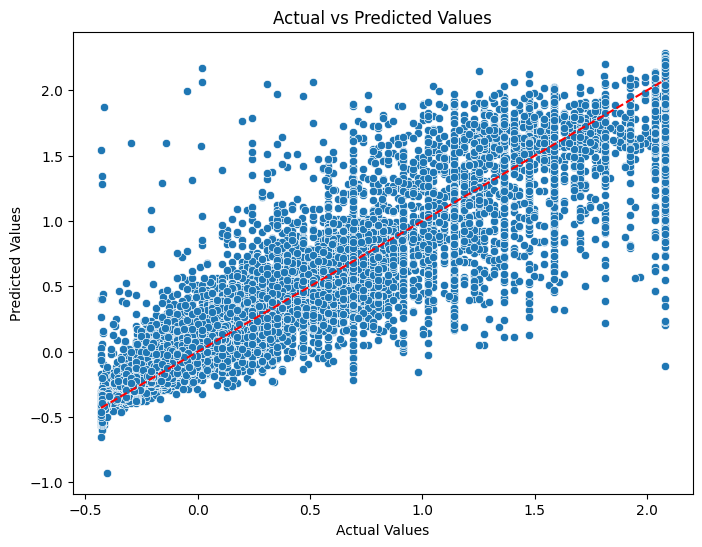

In [77]:
y_true = np.ravel(y_test)
y_pred = np.ravel(y_pred)

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--') # Diagonal line representing perfect prediction
plt.show()

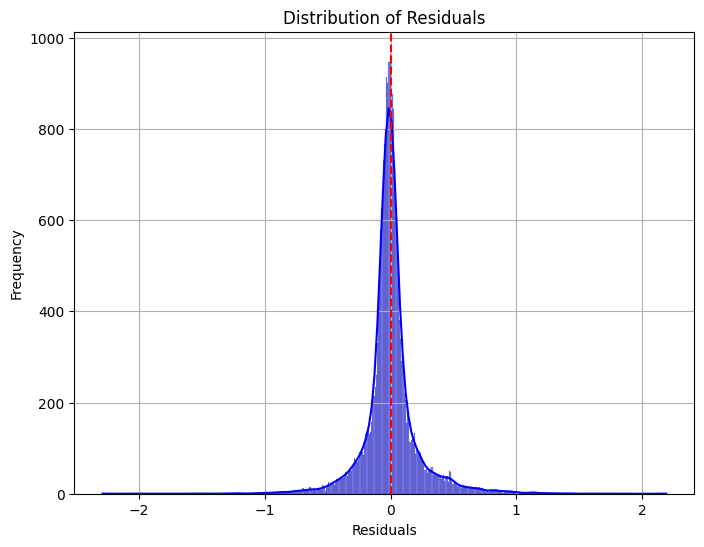

In [78]:
# Assuming svr_model is your trained SVR model and X_test, y_test are your test features and labels
predicted_values = y_pred
residuals = y_true - predicted_values

# Plotting the distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)  # Add grid lines for better readability
plt.axvline(x=0, color='red', linestyle='--')
plt.show()


In [83]:
X_test

,property_type,city,province_name,purpose,location,agent,agency,baths,bedrooms,Area Size
84467,0.495936,0.047120,0.047120,-0.425637,-0.151996,-0.403667,-0.341803,0.2,0.333333,-0.222222
75467,-0.034886,0.047120,0.047120,-0.425637,-0.110208,0.322744,-0.009093,0.2,0.333333,0.222222
143215,0.495936,-0.122191,0.356679,-0.425637,-0.360700,-0.014792,-0.012973,-0.6,-1.000000,0.555556
92279,0.495936,0.619505,0.356679,0.539992,0.769079,0.593994,0.612039,0.6,1.000000,1.333329
29232,0.495936,0.047120,0.047120,0.539992,0.063591,0.475567,0.108617,-0.6,-1.000000,0.488889
...,...,...,...,...,...,...,...,...,...,...
82043,0.495936,0.619505,0.356679,0.539992,0.043522,0.115736,0.106495,0.0,0.000000,-0.333333
28741,0.495936,0.619505,0.356679,0.539992,0.581095,0.311842,0.537207,0.4,0.666667,1.333329
52575,0.495936,0.292763,0.292763,0.539992,0.769079,0.491103,0.483708,0.2,0.333333,1.333329
29707,-0.034886,0.292763,0.292763,-0.425637,0.125949,0.156327,0.003554,-0.2,-0.333333,-0.444444


# hesitation is defeat